# *Tracking the gradient using the Hessian: A new look at variance reducing stochastic methods*, 2018, Robert Gower, Nicolas Le Roux, Francis Bach

### Chloe Baraille & Othmane Sebbouh

In this notebook we implement the modified SVRG proposed in *Tracking the gradient using the Hessian: A new look at variance reducing stochastic methods* and benchmark it against SVRG. This modified SVRG uses the Hessian to track gradient over time. We implement three methods to approximate efficiently the Hessian:
- Diagonal approximation
- Low rank approximation: Curvature Matching
- Low rank approximation: Action Matching

We use the *data_orsay_2017* data set. It contains training data and testing data for a binary classification problem with $d=100$, $n=10 000$ training observations, and $n=100 000$ testing observations. We implement the algorithm on the minimization of the least squares and logistic regressions with a $l_2$ regularizer.

The data set is joint to the report and the notebook or can be found here: http://www.di.ens.fr/~fbach/orsay2018.html.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b

In [2]:
data = loadmat('data_orsay_2017.mat')

In [3]:
n = 1000
X_test = data['Xtest']
y_test = np.array([float(elt) for elt in data['ytest']])
X_train = data['Xtrain'][:n, :]
y_train = np.array([float(elt) for elt in data['ytrain']])[:n]

## 1.Functions

We want to minimize
$$
F(x) = \frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2 =  \frac 1n \sum_{i=1}^n f_i(x)
$$
where
- $\ell(a_i^\top x, b_i) = (b_i - a_i^\top x)^2$ (least-squares regression)
- $\ell(a_i^\top x, b_i) = \log(1 + \exp(-b_i a_i^\top x))$ (logistic regression)

### (a) Linear regression

In [4]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
        self.name = "Linear regression"

    def loss(self, x):
        """Function F"""
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad(self, x):
        """Gradient of F"""
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def grad_i(self, i, x):
        """Gradient of f_i"""
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x
    
    def hessian(self, x):
        """Hessian of F"""
        return self.A.T.dot(self.A) / self.n + self.lbda * np.eye(self.d)
    
    def hessian_i(self, i, x):
        """Hessian of f_i"""
        a_i = self.A[i]
        return np.outer(a_i, a_i) + self.lbda * np.eye(self.d)
    
    def diag_hessian_i(self, i, x):
        """Diagonal elements of the Hessian of f_i"""
        a_i = self.A[i]
        return a_i ** 2 + self.lbda

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient of F"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

**Check gradients**

In [5]:
from scipy.optimize import check_grad

n = X_train.shape[0]
d = X_train.shape[1]

lbda = 1. / n ** (0.5)
model = LinReg(X_train, y_train, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

4.3971840188937156e-07

### (b) Logistic regression

In [6]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
        self.name = "Logistic regression"
        
    def loss(self, x):
        """Function F"""
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad(self, x):
        """Gradient of F"""
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad
    
    def grad_i(self, i, x):
        """Gradient of f_i"""
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def hessian(self, x):
        """Hessian of F"""
        bAx = self.b * np.dot(self.A, x)
        exp_bAx = np.exp(bAx)
        temp = exp_bAx / (1 + np.exp(bAx)) ** 2
        temp = np.expand_dims(temp, 1)
        P = temp * self.A
        return 1 / n * np.dot(P.T, self.A) + self.lbda * np.eye(len(x))
    
    def hessian_i(self, i, x):
        """Hessian of f_i"""
        temp = np.exp(self.b[i] * np.dot(self.A[i], x)) / (1 + np.exp(self.b[i] * np.dot(self.A[i], x)))**2 
        return temp * np.outer(self.A[i].T, self.A[i]) + self.lbda * np.eye(self.d)
    
    def diag_hessian_i(self, i, x):
        """Diagonal elements of the Hessian of f_i"""
        a_i = self.A[i]
        b_i = self.b[i]
        exp_bAx = np.exp(b_i * np.dot(a_i, x))
        return b_i ** 2 * exp_bAx / (1 + exp_bAx) ** 2 * a_i ** 2 + self.lbda
    
    def lipschitz_constant(self):
        """Lipschitz constant of the gradient of F"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

**Check gradients**

In [7]:
lbda = 1. / n ** (0.5)
model = LogReg(X_train, y_train, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.753184589320139e-07

## 2. Inspector

We define an inspector to track the errors of the algorithms. As a reference, we use L-BFGS as implemented in scipy.

In [8]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), 
                                  ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [9]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

## 3. Classic SVRG

We recall that SVRG writes:

Choose $\bar{\theta}_0 \in \mathbf{R}^d$ and step size $\gamma > 0$

For $k=0,...,K-1$:
- Calculate $g(\bar{\theta}_k) = \frac{1}{N} \sum_{j=1}^N g_j(\bar{\theta}_k)$, $\theta_0 = \bar{\theta}_k$
- For $t=0,...,T-1$:
    - Pick i uniformly at random
    - $\theta_{t+1} = \theta_t - \gamma \left( g_i(\theta_t) - g_i(\bar{\theta}_k) + g(\bar{\theta}_k) \right)$
- $\bar{\theta}_{k+1} = \theta_T$

Output $\bar{\theta}_K$

In [10]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter): # n_iter = T * K
        
        if idx % n == 0: # Update of the gradient in the outer loop
            mu = grad(x)
            x_old = x.copy()
        
        i = iis[idx]
        x -= step * (grad_i(i, x) - grad_i(i, x_old) + mu) # Update of x in the inner loop
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

## 4. Tracking gradients with second order control variates

### (a) SVRG2: tracking the gradients with the full Hessian

We first implement the SVRG2 algorithm which is a modifiation of SVRG using full Hessians. SVRG2 writes:


Choose $\bar{\theta}_0 \in \mathbf{R}^d$ and step size $\gamma > 0$

For $k=0,...,K-1$:
- Calculate $g(\bar{\theta}_k) = \frac{1}{N} \sum_{j=1}^N g_j(\bar{\theta}_k)$, $\underline{H(\bar{\theta}_k) = \frac{1}{N} \sum_{j=1}^N H_j(\bar{\theta}_k)}$, $\theta_0 = \bar{\theta}_k$
- For $t=0,...,T-1$:
    - Pick i uniformly at random
    - $\theta_{t+1} = \theta_t - \gamma \left( g_i(\theta_t) - g_i(\bar{\theta}_k) - \underline{H_i(\bar{\theta}_k)(\theta_t - \bar{\theta}_k)} + g(\bar{\theta}_k) + \underline{H(\bar{\theta}_k)(\theta_t - \bar{\theta}_k) } \right)$
- $\bar{\theta}_{k+1} = \theta_T$
  
Output $\bar{\theta}_K$


In [11]:
def svrg2(x_init, iis, grad, grad_i, hessian, hessian_i, n_iter, step, callback=None):
    """SVRG2 with second order approximation"""
    x = x_init.copy()
    x_old = x.copy()
    outer_update = 0
    
    for idx in range(n_iter):
        
        if idx % n == 0:
            mu = grad(x)
            hess = hessian(x)
            x_old = x.copy()
        
        i = iis[idx]
        x -= step * (grad_i(i, x) - grad_i(i, x_old) + mu - hessian_i(i, x).dot(x-x_old) + hess.dot(x-x_old))
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

### (b) Diagonal approximation

We implement a first approximation of the hessian which is called diagonal approximation. It writes:

$$
\hat{H}_i =  \frac{(\theta_t - \bar{\theta}) \odot (g_i(\theta_t) - g_i(\bar{\theta})) + \sigma^2 diag(H_i(\bar{\theta})) }{(\theta_t - \bar{\theta}) \odot (\theta_t - \bar{\theta}) + \sigma^2}
$$

In [12]:
def hess_diag_i(i, x, x_old, diff_x, diff_grad_i, hessian_i, diag_hessian_i, sigma_sq):
    """Function that computes the diagonal approximation of the Hessian based on the above"""
    numerator = diff_x * diff_grad_i + sigma_sq * diag_hessian_i(i, x_old)
    denominator = diff_x ** 2 + sigma_sq * 2
    return np.diag(numerator / denominator)

In [13]:
def svrg_diag(x_init, iis, grad, grad_i, hessian, hessian_i, diag_hessian_i, n_iter, step, sigma_sq, callback=None):
    """SVRG2 with diagonal approximation"""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter):
        
        if idx % n == 0:
            mu = grad(x)
            x_old = x.copy()
            hess = hessian(x_old)
        
        i = iis[idx]
        
        grad_i_new = grad_i(i, x)
        grad_i_old = grad_i(i, x_old)
        diff_grad_i = grad_i_new - grad_i_old
        diff_x = x - x_old
        
        approx = hess_diag_i(i, x, x_old, diff_x, diff_grad_i, hessian_i, diag_hessian_i, sigma_sq)
        
        x -= step * (diff_grad_i + mu - approx.dot(diff_x) + hess.dot(diff_x))
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

### (c) Low rank approximation: Curvature Matching

We implement the curvature matching algorithm. It writes:

Choose $\bar{\theta}_0 \in \mathbf{R}^d$ and step size $\gamma > 0$
For $k=0,...,K-1$:
- Calculate $g(\bar{\theta}_k) = \frac{1}{N} \sum_{j=1}^N g_j(\bar{\theta}_k)$, $\theta_0 = \bar{\theta}_k$
- Calculate $A = \frac{1}{N} \sum_{j=1}^N H_j(\bar{\theta})S$, $C = (S^TA)^{\dagger/2}$
- Generate $S \in \mathbf{R}^{d \times k}$, calculate $\bar{S} = SC$
- Normalize the Hessian action $\bar{A} = AC$
- For $t=0,...,T-1$:
    - Pick i uniformly at random
    - $d_t = g_i(\theta_t) - g_i(\bar{\theta}_k) + g(\bar{\theta}_k) - \bar{A}\bar{S}^TH_i(\bar{\theta}_k) \bar{S} \bar{A}^T (\theta_t - \bar{\theta}_k) + \bar{A}\bar{A}^T(\theta_t - \bar{\theta}_k) $
    - $\theta_{t+1} = \theta_t - \gamma d_t$ 
- $\bar{\theta}_{k+1} = \theta_T$

Output $\bar{\theta}_K$

As in the article, we compute $S$ using the last directions:

In [14]:
from scipy.linalg import sqrtm

In [15]:
def svrg_cm(x_init, iis, grad, grad_i, hessian, hessian_i, n_iter, step, k=10, callback=None):
    """SVRG2 with Curvature Matching Hessian approximation"""
    x = x_init.copy()
    x_old = x.copy()
    #d = x.shape[0]
    S = np.random.randn(d, k) # S as random for the first iteration of the outer loop
    ds = []
    batch_size = np.int(n / k)
    
    for idx in range(n_iter):
        
        if idx % n == 0:
            
            for j in range(k):
                S[j] = np.int(k / n) * np.sum(ds[j:j + batch_size]) # Update of S based on the T previous directions
            ds = []
            
            mu = grad(x)
            A = hessian(x).dot(S)
            C = sqrtm(np.linalg.pinv(S.T.dot(A)))
            S_bar = S.dot(C)
            A_bar = A.dot(C)
            x_old = x.copy()            
        
        i = iis[idx]
        
        prod1 = A_bar.dot(S_bar.T).dot(hessian_i(i, x_old)).dot(S_bar).dot(A_bar.T).dot(x - x_old)
        prod2 = A_bar.dot(A_bar.T).dot(x - x_old)
        dt = grad_i(i, x) - grad_i(i, x_old) + mu - prod1 + prod2
        x -= step * dt
        ds.append(dt)
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

### (d) Low rank approximation: Action Matching

We implement the action matching algorithm. It writes:
    
Choose $\bar{\theta}_0 \in \mathbf{R}^d$ and step size $\gamma > 0$
For $k=0,...,K-1$:
- Calculate $g(\bar{\theta}_k) = \frac{1}{N} \sum_{j=1}^N g_j(\bar{\theta}_k)$, $\theta_0 = \bar{\theta}_k$
- Calculate $A = \frac{1}{N} \sum_{j=1}^N H_j(\bar{\theta})S$, $C = (S^TA)^{\dagger/2}$
- Generate $S \in \mathbf{R}^{d \times k}$, calculate $\bar{S} = SC$
- Normalize the Hessian action $\bar{A} = AC$
- For $t=0,...,T-1$:
    - Pick i uniformly at random
    - $d_t = g_i(\theta_t) - g_i(\bar{\theta}_k) + g(\bar{\theta}_k) - \left( \bar{A}\bar{S}^T H_i(\bar{\theta}_k) (I -\bar{S} \bar{A}^T) + H_i(\bar{\theta}_k) \bar{S} \bar{A}^T \right) (\theta_t - \bar{\theta}_k) + \bar{A}\bar{A}^T(\theta_t - \bar{\theta}_k) $
    - $\theta_{t+1} = \theta_t - \gamma d_t$ 
- $\bar{\theta}_{k+1} = \theta_T$
 
Output $\bar{\theta}_K$

In [16]:
def svrg_am(x_init, iis, grad, grad_i, hessian, hessian_i, n_iter, step, k=10, callback=None):
    """SVRG2 with Action Matching Hessian approximation"""
    x = x_init.copy()
    x_old = x.copy()
    
    S = np.random.randn(d, k)
    ds = []
    batch_size = np.int(n / k) 
    
    for idx in range(n_iter):
        
        if idx % n == 0:
            
            for j in range(k):
                S[j] = np.int(k / n) * np.sum(ds[j:j + batch_size])
            ds = []
            
            mu = grad(x)
            A = hessian(x).dot(S)
            C = sqrtm(np.linalg.pinv(S.T.dot(A)))
            S_bar = S.dot(C)
            A_bar = A.dot(C)
            x_old = x.copy()
        
        i = iis[idx]
        
        prod1 = (A_bar.dot(S_bar.T).dot(hessian_i(i, x_old)).dot(np.eye(d) - S_bar.dot(A_bar.T)) + 
                 hessian_i(i, x_old).dot(S_bar).dot(A_bar.T)).dot(x - x_old)
        prod2 = A_bar.dot(A_bar.T).dot(x - x_old)
        dt = grad_i(i, x) - grad_i(i, x_old) + mu - prod1 + prod2
        x -= step * dt
        ds.append(dt)
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

## 3. Plots

### Choice of the model

In [17]:
lbda = 1e-1
model = LogReg(X_train, y_train, lbda) # LogReg or LinReg

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)

In [18]:
f_min

0.6282872425478552

**Choice of step size**: The article proposes a grid search trying values $2^a / L_{max}$, with $a$ depending on the problem.

In [19]:
a = 0
Lmax = np.max(np.sum((model.A**2), axis=1)) + model.lbda
step = 2 ** a / Lmax

### (a) SVRG

In [20]:
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.30e-02 | 8.17e-01 | 1.6001e-02
      10 | 0.00e+00 | 3.07e-09 | 5.1603e-01
      20 | 1.11e-16 | 3.09e-09 | 1.0091e+00
      30 | 1.11e-16 | 3.09e-09 | 1.5011e+00
      40 | 1.11e-16 | 3.09e-09 | 1.8931e+00


### (b) SVRG2

In [21]:
x_init = np.zeros(d)
svrg2_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg2 = svrg2(x_init, iis, model.grad, model.grad_i, model.hessian, model.hessian_i, n * n_iter, step, 
                callback=svrg2_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.30e-02 | 8.17e-01 | 4.8003e-02
      10 | 1.11e-16 | 3.09e-09 | 2.2431e+00
      20 | 1.11e-16 | 3.09e-09 | 4.4243e+00
      30 | 1.11e-16 | 3.09e-09 | 7.2374e+00
      40 | 1.11e-16 | 3.09e-09 | 9.6766e+00


### (c) Diagonal approximation

In [22]:
x_init = np.zeros(d)
svrg_diag_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg_diag = svrg_diag(x_init, iis, model.grad, model.grad_i, model.hessian, model.hessian_i, 
                        model.diag_hessian_i, n * n_iter, step, sigma_sq=0.1, callback=svrg_diag_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.30e-02 | 8.17e-01 | 2.6001e-02
      10 | 3.07e-09 | 1.55e-04 | 1.5121e+00
      20 | 5.55e-16 | 5.32e-08 | 2.9612e+00
      30 | 1.11e-16 | 3.09e-09 | 4.4023e+00
      40 | 1.11e-16 | 3.09e-09 | 5.8513e+00


### (d) Low rank approximation: Curvature Matching

In [23]:
x_init = np.zeros(d)
svrg_cm_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg_cm = svrg_cm(x_init, iis, model.grad, model.grad_i, model.hessian, model.hessian_i, n * n_iter, step, k=10, 
                callback=svrg_cm_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.30e-02 | 8.17e-01 | 2.9001e-02
      10 | 1.11e-16 | 3.07e-09 | 4.8323e+00
      20 | 1.11e-16 | 3.09e-09 | 9.8106e+00
      30 | 1.11e-16 | 3.09e-09 | 1.4503e+01
      40 | 1.11e-16 | 3.09e-09 | 1.9172e+01


### (e) Low rank approximation: Action Matching

In [24]:
x_init = np.zeros(d)
svrg_am_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg_am = svrg_am(x_init, iis, model.grad, model.grad_i, model.hessian, model.hessian_i, n * n_iter, step, k=10, 
                callback=svrg_am_inspector)

   it    |   obj    |   err    |   time  
       0 | 6.30e-02 | 8.17e-01 | 3.9002e-02
      10 | 0.00e+00 | 3.09e-09 | 1.1034e+01
      20 | 1.11e-16 | 3.09e-09 | 2.1926e+01
      30 | 1.11e-16 | 3.09e-09 | 3.4066e+01
      40 | 1.11e-16 | 3.09e-09 | 4.5001e+01


### Plots

Text(0.5,0.98,'Logistic regression with $\\lambda$ = 0.1')

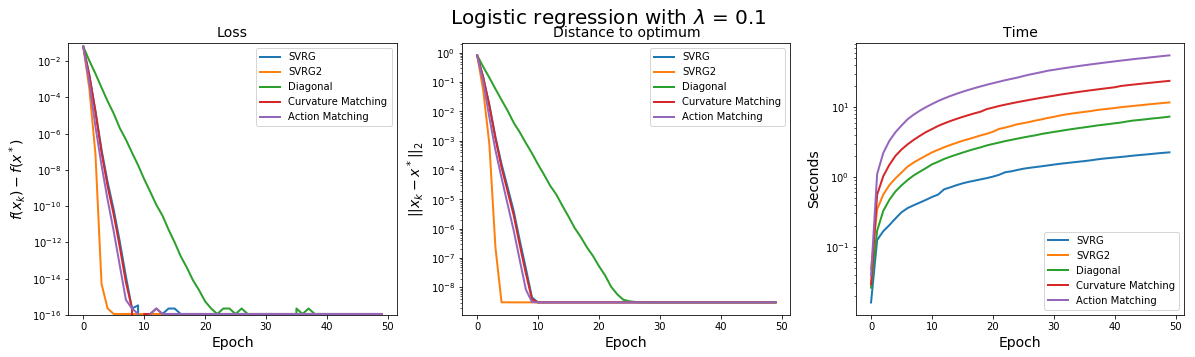

In [25]:
inspectors = [svrg_inspector, svrg2_inspector, svrg_diag_inspector, svrg_cm_inspector, svrg_am_inspector]
solvers = ["SVRG", "SVRG2", "Diagonal", "Curvature Matching", "Action Matching"]

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.ylim(1e-16, 0.1)

plt.legend(solvers)

plt.subplot(1, 3, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$||x_k - x^*||_2$", fontsize=14)
    
plt.legend(solvers)
    
plt.subplot(1, 3, 3)

for insp in inspectors:
    plt.semilogy(insp.timing, lw=2)
    plt.title("Time", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Seconds", fontsize=14)    

plt.legend(solvers)

plt.suptitle("{} with $\lambda$ = {}".format(model.name, lbda), fontsize=20)

**Comments**

- **SVRG vs SVRG2**: SVRG2 converges faster than SVRG in terms of iterations, as each control variate depends on the previous iteration of the inner loop, contrary to SVRG where the control variates are updated only at each iteration of the outer loop. Moreover, this characteristic of SVRG2 robustifies the algorithm to the choice of step size. However, computing the full Hessian at each iteration of the outer loop induces a computational cost, which is why SVRG2 is slower than SVRG in terms of time. It also induces a large storage cost.
- **Diagonal approximation**: This approximation enables to speed up SVRG2 (in terms of seconds per iteration) as it induces a smaller computational cost. The convergence is however slower is terms of iterations. It reduces the storage cost compared to SVRG2.
- **Curvature and Action Matching approximations**: These approximtions have the same convergence speed in terms of iterations as SVRG. They are however definitely slower in tems of time, because of the high computational cost (which could be reduced by using automatic differenciation). It reduces the storage cost compared to SVRG2.

On most problems, SVRG seems to be the best solution.